In [1]:
import numpy as np
import datetime
import pandas as pd

In [2]:
''' Process dataset, extract features. '''

# A dictionary for containing raw features.
features = {}

""" 
读取数据集
字段：日期时间，天气，wifi状态，位置坐标，电池电量，上次打开应用包名，本次打开应用包名，耳机状态，蓝牙状态，是否周末（未使用此字段）
示例数据：2018/11/15 18:57:34,-1,-1,113.569399_22.372674,100,com.UCMobile,com.tencent.mm,0,0,0
"""
# Read the data file.
dataset = np.loadtxt(r'dataset/dataset5.log',dtype='str',delimiter=',')

"""
1. 提取直接的特征： 天气、WiFi状态、电池电量、上次打开应用包名、耳机状态、蓝牙状态、本次打开应用包名。 
2. 对齐时间点： 丢弃“上次打开应用”、“本次打开应用”的第一行，丢弃其他属性的最后一行，
使得“上次打开应用”变为“本次打开应用(curr_app)”，“本次打开应用”变为“下次打开应用(next_app)”。
"""
# Get simple features.
features['weather'] = [int(line[1]) for line in dataset[:-1]]
features['wifi_status'] = [int(line[2]) for line in dataset[:-1]]
features['battery'] = [int(line[4]) for line in dataset[:-1]]
features['curr_app'] = [line[5] for line in dataset[1:]]
features['earphone'] = [int(line[7]) for line in dataset[:-1]]
features['bluetooth'] = [int(line[8]) for line in dataset[:-1]]
features['next_app'] = [line[6] for line in dataset[1:]]

"""
3. 填充缺失包名： 将“本次打开应用包名”中为null的记录全部填充为上一行中的“下次打开包名”。 
    如：
        2018/11/15 18:01:46,-1,-1,113.569399_22.372674,100,com.tencent.mobileqq,com.UCMobile,0,0,0
        2018/11/15 18:06:04,-1,-1,113.569399_22.372674,100,null,com.UCMobile,0,0,0
        第二行中的null用第一行的“com.UCMobile”填充。
"""
for i in range(1,len(features['curr_app'])):
    if features['curr_app'][i] == 'null':
        features['curr_app'][i] = features['next_app'][i-1]

""" 
4. 时间 -> 周日期(weekday)、时段(hour)：
	1) 周日期即当天为周几。
	2) 时段精确到分钟。如18:30:25转化为18+30/60=18.5。
    如：由字段值“2018.12.25 18:30:25”可得到新特征
            weekday: 2
            hour: 18.5
"""
# Get hour and weekday.
date_time = [datetime.datetime.strptime(line[0],'%Y/%m/%d %H:%M:%S') for line in dataset[:-1]]
features['hour'] = [float(dt.hour)+float(dt.minute)/60 for  dt in date_time]
features['weekday'] = [dt.weekday() for dt in date_time]

"""
5. 应用上次打开时间(last_open_time)：
	1) 根据特征： 本次打开应用包名、时间  
	2) 精确到秒，即计算本次打开的应用距离上次打开经过了多少秒。
	3) 数据集中第一次出现该应用的记录将这一特征的值填充为1296000（一个月）。
    如：
        2018/11/15 19:09:07,-1,-1,113.569299_22.372701,100,com.alibaba.android.rimet,com.tencent.mobileqq,0,0,0
        2018/11/15 19:09:24,-1,-1,113.569299_22.372701,100,com.tencent.mobileqq,com.alibaba.android.rimet,0,0,0
        2018/11/15 19:09:30,-1,-1,113.569299_22.372701,100,com.alibaba.android.rimet,com.UCMobile,0,0,0
        
        假设第一行为数据集中第一行，则此处应用“com.alibaba.android.rimet”的上次打开时间填充为1296000
        处理第三行时，应用“com.alibaba.android.rimet”的上次打开时间即 2018/11/15 19:09:30 - 2018/11/15 19:09:07 = 23
"""
# Get last open time.
features['last_open_time'] = []
for counter, la in enumerate(features['curr_app']):
    last_open_time = 1296000
    for i in range(counter):
        if features['curr_app'][counter-1-i] == la:
            last_open_time = (date_time[counter] - date_time[counter-1-i]).seconds
            break
    features['last_open_time'].append(last_open_time)

"""
6. 经度(longitude)、纬度(latitude)：根据坐标得到。
    如：
        根据字段值“113.569399_22.372674”得到新特征：
            longitude: 113.569399
            latitude: 22.372674
"""
# Get  coordinates.
coordinates =  [line[3] for line in dataset[:-1]]
features['longitude'] = []
features['latitude'] = []
for c in coordinates:
    if c in 'unknown' or c in 'null':
        features['longitude'].append(np.nan)
        features['latitude'].append(np.nan)
    else:
        features['longitude'].append(float(c.split('_')[0]))
        features['latitude'].append(float(c.split('_')[1]))

"""
7. 应用分类(categories)：
	1) 根据特征： 本次打开应用包名 
	2) 从top2000应用分类数据中查找分类
	3) 根据包名关键词分类
    如：
        根据字段值“com.tencent.mm”得到
            categories: “通讯社交”
"""
# Get categories.
app_cat = pd.read_excel('Top2000应用.xlsx')
features['categories'] = []
for a in features['curr_app']:
    if a in app_cat.to_dict(orient='list')['包名']:
        features['categories'].append(app_cat['应用分类'][np.where(app_cat['包名'] == a)[0][0]])
    elif 'calculator' in a or 'dialer' in a or 'setting' in a or 'store' in a or 'weather' in a or 'blockchain' in a or 'clock' in a or 'assistant' in a or 'center' in a or 'android' in a:
        features['categories'].append('系统工具')
    elif 'com.meizu.compaign' in a or 'com.meizu.flymelab' in a or 'com.meizu.filemanager' in a or 'com.meizu.notepaper' in a or 'com.meizu.feedback' in a or 'com.meizu.flyme.toolbox' in a or 'com.meizu.mznfcpay' in a or  'com.meizu.safe' in a:
        features['categories'].append('系统工具')
    elif 'media' in a or 'video' in a or 'camera' in a or 'photo' in a or 'tv' in a or 'com.tencent.qqlive.player.meizu' in a:
        features['categories'].append('影音图像')
    elif 'health' in a or 'sport' in a:
        features['categories'].append('运动健康')
    elif 'email' in a or 'message' in a:
        features['categories'].append('通讯社交')
    else:
        features['categories'].append('其他')

"""
8. 应用打开频率（frequency）：
	1) 根据特征： 本次打开应用包名
	2) 根据“本次应用包名”在整个数据集中出现的次数计算出。
"""
# Get frequency.
features['frequency'] = []
apps_freq = {}
for lp in features['curr_app']:
    if lp in apps_freq:
        apps_freq[lp] += 1
    elif lp == 'null':
        apps_freq['null'] = np.nan
    else:
        apps_freq[lp] = 1
        
for lp in features['curr_app']:
    features['frequency'].append(apps_freq[lp]) 


"""
9. 使用时长(use_time)：
	1) 根据特征： 本次打开应用包名、下次打开应用包名、时间 
	2) 计算当前打开应用在数据集中的平均使用时长，每一次使用时长由下一条记录的时间点减去当前记录的时间点得到。
	3) 该特征最终未使用。
"""    
# Get app average used time.
features['use_time'] = []
use_time = {}
for i in range(len(features['curr_app'])-1):
    if features['curr_app'][i] in use_time:
        use_time[features['curr_app'][i]].append((date_time[i+1] - date_time[i]).seconds)
    else:
        use_time[features['curr_app'][i]] = [(date_time[i+1] - date_time[i]).seconds]

for ut in use_time:
    use_time[ut] = np.mean(use_time[ut])
    
for lp in features['curr_app']:
    features['use_time'].append(use_time[lp])
    
"""
10. 填充缺失值：
	1) 将耳机状态、蓝牙状态、WiFi状态的缺失值由-1改为0.5，方便归一化。
	2) 将应用打开频率的缺失值填充为中值。
	3) 将经度、纬度的缺失值填充为均值。
"""
#  Handle missing values.
earphone = [0.5 if e == -1 else e for e in features['earphone']]
features['earphone'] = earphone

bluetooth = [0.5 if b == -1 else b for b in features['bluetooth']]
features['bluetooth'] = bluetooth

wifi = [0.5 if ws == -1 or ws == 2 else ws for ws in features['wifi_status']]
features['wifi_status'] = wifi

frequency = pd.DataFrame(features['frequency'])
frequency.fillna(frequency.median(),inplace=True)
features['frequency'] = frequency[0].tolist()

longitude = pd.DataFrame(features['longitude'])
longitude.fillna(longitude.mean(),inplace=True)
features['longitude'] = longitude[0].tolist()

latitude = pd.DataFrame(features['latitude'])
latitude.fillna(latitude.mean(),inplace=True)
features['latitude'] = latitude[0].tolist()

"""
11. 地理位置类型(poi)：
	1) 根据特征：经度、纬度。
	2) 第一次：使用高德的api访问http地址得到返回的json文件后提取出“poi”字段的值的第一个记录中的“type”字段的值。
	3) 对于一份数据集，第一次得到此特征之后保存在一个txt文件中。
	4) 第一次之后：直接读取保存本地的txt文件获取此特征。
    如：
        根据经纬度113.5788200000,22.2758300000
        访问https://restapi.amap.com/v3/geocode/regeo?output=xml&location=113.5788200000,22.2758300000&key=50b7513606eb24d880340825aa814160&radius=50&extensions=all
        得到poi类型“购物服务;商场;购物中心”
"""
# Get poi.
''' Using api, translate pois and save them to a text file. '''
features['poi'] = []
# import requests
# keys = ['3d6a65500d61192106d0d9d27ea6953f', '11f9714e1e89c531c8d5c7b1d5fc1d5c', '50b7513606eb24d880340825aa814160', 'f5e156204f7a5012a49c681c9ec4aa5a', 'dfe1fb662ecbb07fb88393b4bae401da']
# for i in range(len(features['longitude'])):
#     long = features['longitude'][i]
#     lat = features['latitude'][i]
#     key = keys[4]
#     r = requests.get('https://restapi.amap.com/v3/geocode/regeo?output=json&location='+
#                      str(long)+','+str(lat)+'&key='+key+'&radius=50&extensions=all')
#     env = np.nan
#     if r.status_code == 200:
#         if len(r.json()['regeocode']['pois']) > 0:
#             env = r.json()['regeocode']['pois'][0]['type']
#     features['poi'].append(str(env))
# np.savetxt('poi/poi6.txt', features['poi'], fmt='%s')

''' Read from text. '''
poi = np.loadtxt('poi/poi5.txt',encoding='utf8',dtype=str)
poi = pd.DataFrame(poi)
features['poi'] = poi[0].tolist()

"""
打印所有特征。
"""
# Print raw features.
print('\n*************** RAW FEATURES ***************\n')
for f in features:
    print(f, ': \n', features[f][:30], '\n')


"""
12. 处理连续值：
	1) 连续型特征有：电池电量、应用打开频率、经度、纬度、时段、耳机状态、蓝牙状态、wifi状态、周日期、上次打开时间。
	2) 对所有连续型特征进行归一化。
"""
''' Process continious values. '''
# Normalization.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_con = np.matrix([features['battery'], features['frequency'], features['longitude'], features['latitude'], features['hour'], features['earphone'], 
                   features['bluetooth'], features['wifi_status'], features['weekday'], features['last_open_time']]).T
X_con = scaler.fit_transform(X_con)

"""
13. 处理离散值：
	1) 离散型特征有：地理位置类型、应用分类、本次打开应用、天气。
	2) 对所有离散型特征进行label encoding（若要进行one hot encoding则剔除本次打开应用）。
"""
''' Process categorical values. '''
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
lenc = LabelEncoder()
enc = OneHotEncoder()
lb = LabelBinarizer()
features['poi'] = LabelEncoder().fit_transform(features['poi'])
features['categories'] = LabelEncoder().fit_transform(features['categories'])
features['curr_app'] = LabelEncoder().fit_transform(features['curr_app'])
features['weather'] = LabelEncoder().fit_transform(features['weather'])
# X_cat = np.matrix([features['categories'], features['poi'], features['weather']]).T
# X_cat = enc.fit_transform(X_cat).toarray()
X_cat = np.matrix([features['poi'], features['categories'], features['curr_app'], features['weather']]).T
print('X_cat: \n', X_cat)

"""
14. 构建特征矩阵X：n×14。
"""
''' Prepare X. '''
print('\n*************** X MATRIX ***************\n')
print('X_con: ', X_con.shape)
print('X_cat: ', X_cat.shape)
X = np.concatenate((X_con.T,X_cat.T)).T
print('X shape: ', X.shape)
print('X: \n', X)
np.savetxt('X.txt', X, fmt='%s')

"""
16. 过滤低频应用以及一些无法处理的系统应用，筛选80%的高频应用作为待预测的类别。
"""
''' Select classes to predict. '''
filtered = ['com.flyme.systemuiex', 'com.flyme.roamingpay', 'com.flyme.design', 'com.meizu.powersave', 'jp.co.hit_point.tabikaeru.meizu', 'com.meizu.flyme.xtemui', 'com.meizu.mzsyncservice', 'com.meizu.account',  'com.meizu.perfui', 'com.meizu.flyme.easylauncher', 'com.meizu.mzbasestationsafe', 'com.meizu.battery', 'com.meizu.share']
import queue as Q
pq = Q.PriorityQueue()
for f in apps_freq:
    if f not in filtered:
        pq.put((-apps_freq[f], f))
label = []
for i in range(int(0.8*len(apps_freq))):
    label.append(pq.get()[1]) 

"""
17. 构建标签向量Y：n×1。
"""
''' Prepare Y. '''
print('\n*************** Y VECTOR ***************\n')

Y = []
options = set()
others_num = 0
for np in features['next_app']:
    if np not in label:
        Y.append('others') 
        others_num += 1
    else:
        Y.append(np)

print('#others: ',others_num)
# np.savetxt('Y.txt', Y, fmt='%s')
with open("Y.txt", "w") as text_file:
    for y in Y:
         text_file.write("%s\n" % y)

for y in Y:
    options.add(y)
print('Y: ', options)

"""
18. 划分训练集和测试集。
"""
''' Split train and test. '''
print('\n*************** TRAIN AND TEST ***************\n')
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
print('training set size: ', X_train.shape[0])
print('test set size: ', X_test.shape[0])





*************** RAW FEATURES ***************

bluetooth : 
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

categories : 
 ['其他', '系统工具', '通讯社交', '系统工具', '通讯社交', '系统工具', '系统工具', '通讯社交', '影音图像', '网上购物', '金融理财', '网上购物', '系统工具', '网上购物', '网上购物', '通讯社交', '网上购物', '系统工具', '网上购物', '通讯社交', '通讯社交', '系统工具', '系统工具', '通讯社交', '通讯社交', '通讯社交', '通讯社交', '通讯社交', '通讯社交', '通讯社交'] 

next_app : 
 ['com.UCMobile', 'com.tencent.mobileqq', 'com.UCMobile', 'com.tencent.mobileqq', 'com.UCMobile', 'com.UCMobile', 'com.tencent.mm', 'com.netease.cloudmusic', 'com.jingdong.app.mall', 'com.jingdong.app.mall', 'com.jingdong.app.mall', 'com.android.mms', 'com.jingdong.app.mall', 'com.jingdong.app.mall', 'com.tencent.mm', 'com.jingdong.app.mall', 'com.meizu.flyme.calculator', 'com.jingdong.app.mall', 'com.tencent.mm', 'com.tencent.mobileqq', 'com.UCMobile', 'com.UCMobile', 'com.tencent.mm', 'com.tencent.mm', 'com.tencent.mobileqq', 'com.tencent.mobileqq', 'com.tencent.mm', 'c

In [3]:
"""
用以评估模型的函数。
评估方式：
    对与一个实例，根据预测参数num，返回num个预测结果，
    预测多个结果的方式：用predict_proba函数得到各个待预测类别的预测概率，根据概率排序，返回前num个
    在num个预测结果中若有一个与真实标签匹配，则此实例预测正确，记为1；否则此实例预测错误，记为0
    将数据集中所有实例的预测结果求平均值即得到此模型在该数据集的预测准确度。
"""

def evaluate(Y_pred_proba, classes, Y_test, num=4):
   ''' A function used to evaluate models. '''
    import numpy as np
    Y_pred = [[] for i in Y_pred_proba]
    for c,v in enumerate(Y_pred_proba):
        class_proba = {}
        for i in range(len(classes)):
            class_proba[classes[i]] = v[i]
        Y_pred[c] = sorted(class_proba, key=class_proba.get, reverse=True)[:num]
    result = []
    for i in range(len(Y_pred)):
        if Y_test[i] in Y_pred[i] and Y_test[i] is not 'others':
            result.append(1)
        else:
            result.append(0)
    accuracy = np.mean(result)
    return accuracy

In [4]:
"""
一个简单的预测算法，用以提供衡量ML模型效果的基准准确度。
预测方式：将所有应用根据其在数据集中被打开的频率排序，返回前num个作为预测结果。
"""
def benchmark(Y_test, num=4):
    ''' A simple function which returns the apps with highest frequencies in the dataset. Used as the benchmark for ML models. '''
    import numpy as np
    result = []
    for i in range(len(Y_test)):
        if Y_test[i] in label[:num]:
            result.append(1)
        else:
            result.append(0)
    accuracy = np.mean(result)
    return accuracy


*************** CROSS VALIDATION RESULTS FOR MODELS ***************

*Benchmark:  0.7197768133911965


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Logistic Regression:  0.7724736515809052
Random Forest:  0.8202107873527589
SVM:  0.7972721636701798
Gradient Boosting:  0.8220706757594545


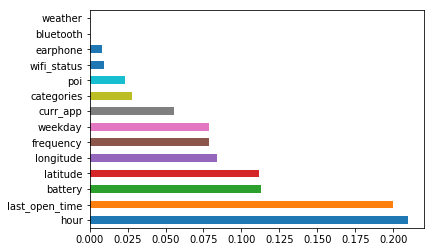

In [5]:
"""
评估多个模型的预测准确度，将其与benchmark比较。
"""
''' Model selection '''
print('\n*************** CROSS VALIDATION RESULTS FOR MODELS ***************\n')

print('*Benchmark: ', benchmark(Y_test))

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1, penalty='l2',multi_class='multinomial',solver='sag')
clf.fit(X_train, Y_train)
Y_pred_proba = clf.predict_proba(X_test)
print('Logistic Regression: ', evaluate(Y_pred_proba, clf.classes_, Y_test))

from sklearn.ensemble import RandomForestClassifier
# rf = RandomForestClassifier(n_estimators=300,criterion='entropy', min_samples_leaf=3, n_jobs = -1,random_state=1)
rf = RandomForestClassifier(n_estimators=741, bootstrap=True , criterion='gini', max_depth=None, max_features=5, min_samples_leaf=5,min_samples_split=2, n_jobs = -1,random_state=9)
rf.fit(X_train, Y_train)
Y_pred_proba = rf.predict_proba(X_test)
print('Random Forest: ', evaluate(Y_pred_proba, rf.classes_, Y_test))

from sklearn.svm import SVC
svm = SVC(probability=True,gamma='auto')
svm.fit(X_train, Y_train)
Y_pred_proba = svm.predict_proba(X_test)
print('SVM: ', evaluate(Y_pred_proba, svm.classes_, Y_test))

from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(X_train, Y_train)
Y_pred_proba = gb.predict_proba(X_test)
print('Gradient Boosting: ', evaluate(Y_pred_proba, gb.classes_, Y_test))


"""
打印随机森林中，各个特征的重要性。
"""
import matplotlib.pyplot as plt
%matplotlib inline
feature_names = ['battery', 'frequency', 'longitude', 'latitude', 'hour', 'earphone', 'bluetooth', 'wifi_status', 'weekday', 'last_open_time', 'poi', 'categories', 'curr_app', 'weather']
importances = rf.feature_importances_
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.nlargest(14).plot(kind='barh')
plt.show()